In [2]:
'''
Calculate/compare and visualize observed (usgs) and simulated (nwm)
annual, monthly volume and daily accumulated volume in WYs 19 and 20

*Reads monthly volume and cumulative daily volume from csv files
created by script 'volume_eval_processing'

'''
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import os
%matplotlib inline
import matplotlib.ticker as ticker
from matplotlib import gridspec
import matplotlib.dates as mdates

### Define directories and filenames

# base working directory
base_dir = 'C:\\repos\\git\\nwm_eval_projects\\annual_runoff'

# define sitelist filename and some parameters
site_list_fname = 'Volumetric_Eval_Sites_3.csv'
site_id_header = 'USGS_ID'
site_num_header = 'Site_Num' # numbered roughly from East to West
reverse_order = True # to plot West to East from left to right, reverse the order

# NWM directory
nwm_dir = 'ts-data\\nwm_ana'

# NWM aggregated time series files
nwm_accum19_fname = "NWM_DailyAccum_WY19.csv"
nwm_accum20_fname = "NWM_DailyAccum_WY20.csv"
nwm_monthly_fname = "NWM_MonthlyVolume_WYs19-20.csv"

# USGS data directory
usgs_dir = 'ts-data\\usgs'

# USGS aggregated time series files
usgs_accum19_fname = "USGS_DailyAccum_WY19.csv"
usgs_accum20_fname = "USGS_DailyAccum_WY20.csv"
usgs_monthly_fname = "USGS_MonthlyVolume_WYs19-20.csv"

In [3]:
def prepare_data(site_ids, read_path, filenames):
    '''
    Read aggregated monthly and daily time series from csv files 
    Do some data reorg, processing and grouping to prepare for plotting
    '''
    # array of water years to tack on to monthly df's
    wy = np.repeat((19,20),(12,12))
    
    # read monthly volumes and daily accumulated volume from csv
    df_mon = pd.read_csv(os.path.join(read_path, filenames[0]), header=0, date_parser=pd.to_datetime)
    df_dailyaccum19 = pd.read_csv(os.path.join(read_path, filenames[1]), header=0, index_col = 0, date_parser=pd.to_datetime)
    df_dailyaccum20 = pd.read_csv(os.path.join(read_path, filenames[2]), header=0, index_col = 0, date_parser=pd.to_datetime)
    
    # select sites by list and order defined in site_ids
    df_mon = df_mon.loc[:,np.append('datetime', site_ids.values)]
    
    # restructure monthly totals to facilitate plotting
    df_mon.insert(0, 'Year', pd.DatetimeIndex(df_mon['datetime']).year)
    df_mon.insert(1, 'Month', pd.DatetimeIndex(df_mon['datetime']).month)
    df_mon.insert(2, 'WY', wy)
    df_mon = df_mon.drop(['datetime'], axis = 1).set_index('Month')
    
    # calculate WY-based annual totals
    df_annual = df_mon.iloc[[0, 12],:].set_index('WY').drop(['Year'],  axis = 1)
    df_annual.loc[19,site_ids] = df_mon.loc[df_mon['WY']==19, site_ids].sum()
    df_annual.loc[20,site_ids] = df_mon.loc[df_mon['WY']==20, site_ids].sum()
    
    # set up dataframes of seasonal totals
    df_seas = df_mon.iloc[np.append(np.arange(4),np.arange(12,16)),:].rename(columns = {'Year':"Season"})
    df_seas['Season'] = np.append(np.arange(1,5),np.arange(1,5))
    df_seas = df_seas.set_index('Season')
    
    # calculate seasonal totals
    seasind = np.array([[10, 11, 12], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
    row = 0
    for wy in range(19,21):       
        for i in range(1, 5):
            df_wy = df_mon.loc[df_mon['WY']==wy]                       
            df_seas.iloc[row, 1:] = df_wy.loc[seasind[i-1,:],site_ids].sum()
            row += 1
    
    data_dict = {}
    data_dict[0] = df_mon
    data_dict[1] = df_seas
    data_dict[2] = df_annual
    data_dict[3] = df_dailyaccum19
    data_dict[4] = df_dailyaccum20
    
    return data_dict

In [4]:
# Get site information
sites_df = pd.read_csv(os.path.join(base_dir, site_list_fname))

if reverse_order: 
    sites_df = sites_df.iloc[::-1, :]  # flip rows if plotting west to east

site_ids =sites_df[site_id_header].astype('string')
for i in range(len(site_ids)):
    site_ids[i] = site_ids[i].zfill(8) #pad string with zeros to 8 digits
sites_df[site_id_header] = site_ids
sites_df = sites_df.set_index('Site_Num')
site_labels_numfirst = sites_df.index.astype('string') + ' - ' + sites_df['Name_Abbrev']
site_labels_numlast = sites_df['Name_Abbrev'] + ' - ' + sites_df.index.astype('string')

In [5]:
# Prepare NWM data
nwm_dict = {}
nwm_path = os.path.join(base_dir, nwm_dir)
nwm_filenames = [nwm_monthly_fname, nwm_accum19_fname, nwm_accum20_fname]
nwm_dict = prepare_data(site_ids, nwm_path, nwm_filenames)
nwm_mon = nwm_dict[0]
nwm_seas = nwm_dict[1]
nwm_annual = nwm_dict[2]
nwm_dailyaccum19 = nwm_dict[3]
nwm_dailyaccum20 = nwm_dict[4]

# Prepare USGS data
usgs_dict = {}
usgs_path = os.path.join(base_dir, usgs_dir)
usgs_filenames = [usgs_monthly_fname, usgs_accum19_fname, usgs_accum20_fname]
usgs_dict = prepare_data(site_ids, usgs_path, usgs_filenames)
usgs_mon = usgs_dict[0]
usgs_seas = usgs_dict[1]
usgs_annual = usgs_dict[2]
usgs_dailyaccum19 = usgs_dict[3]
usgs_dailyaccum20 = usgs_dict[4]

# Calculate error magnitude and percent at each time scale
mon_err_mag = nwm_mon.copy()
mon_err_perc = nwm_mon.copy()
seas_err_mag = nwm_seas.copy()
seas_err_perc = nwm_seas.copy()
annual_err_mag = nwm_annual.copy()
annual_err_perc = nwm_annual.copy()
mon_err_mag.loc[:,site_ids] = nwm_mon.loc[:,site_ids] - usgs_mon.loc[:,site_ids]
mon_err_perc.loc[:,site_ids] = mon_err_mag.loc[:,site_ids] / usgs_mon.loc[:,site_ids] * 100
seas_err_mag.loc[:,site_ids] = nwm_seas.loc[:,site_ids] - usgs_seas.loc[:,site_ids]
seas_err_perc.loc[:,site_ids] = seas_err_mag.loc[:,site_ids] / usgs_seas.loc[:,site_ids] * 100
annual_err_mag.loc[:,site_ids] = nwm_annual.loc[:,site_ids] - usgs_annual.loc[:,site_ids]
annual_err_perc.loc[:,site_ids] = annual_err_mag.loc[:,site_ids] / usgs_annual.loc[:,site_ids] * 100

In [6]:
# temporary - output csv's of annual error for mapping in QGIS
utemp = usgs_annual.copy()
ntemp = nwm_annual.copy()
utemp.loc['2yr', :] = usgs_annual.sum().values
ntemp.loc['2yr', :] = nwm_annual.sum().values

errtemp = pd.DataFrame([np.zeros(len(site_ids))], index = ['19mag'], columns = site_ids)

errtemp.loc['19mag', site_ids] = annual_err_mag.loc[19,site_ids]
errtemp.loc['20mag', site_ids] = annual_err_mag.loc[20,site_ids]
errtemp.loc['2yrmag', site_ids] = ntemp.loc['2yr', site_ids] - utemp.loc['2yr', site_ids]
errtemp.loc['19perc', site_ids] = annual_err_perc.loc[19,site_ids]
errtemp.loc['20perc', site_ids] = annual_err_perc.loc[20,site_ids]
errtemp.loc['2yrperc', site_ids] = errtemp.loc['2yrmag', site_ids] / utemp.loc['2yr', site_ids] * 100

fname = 'annual_error_stats.csv'
path = os.path.join(base_dir, fname)
errtemp.to_csv(os.path.join(base_dir, fname))

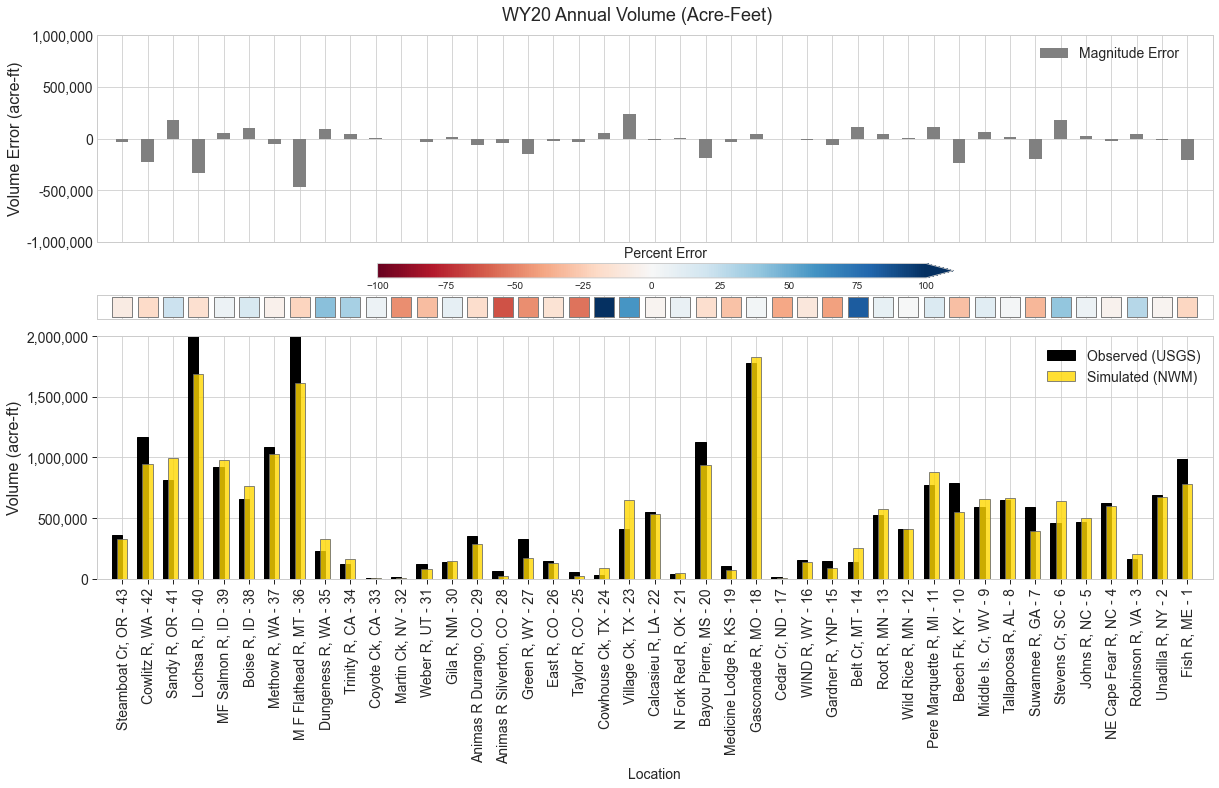

In [7]:
### Begin building figures

# Figure style 1 - volume bar charts with 3 axes, all sites - annual or seasonal timescales
# top - bar chart of error magnitude
# middle - heatmap-esque color blocks indicating percent error
# lower - bar chart of simulated vs. observed

# set time scale (ann or seas), season (1-4) or water year (19-20), title, output filename
timescale = 'A' # 'A' for annual, 'S' for seasonal
wy = 20
seas = 4 # ignored if annual timescale

ylim_bot = 2e6  # set by trial and error
ylim_top = 1e6
yticks_bot = [0,5e5,1e6,1.5e6,2e6]

if timescale == 'A':
    fig_title = 'WY' + str(wy) + ' Annual Volume (Acre-Feet)'
    fig_filename = 'WY' + str(wy) + '_Annual.png'
    usgs_vals = usgs_annual.loc[wy,:]
    nwm_vals = nwm_annual.loc[wy,:]
    err_mag = annual_err_mag.loc[wy,:]
    err_perc = annual_err_perc.loc[wy,:]
    ylim_bot = 2e6  # set by trial and error
    ylim_top = 1e6
    yticks_bot = [0,5e5,1e6,1.5e6,2e6]
    
else:
    season_months = pd.Series(["Oct-Dec", "Jan-Mar", "Apr-Jun", "Jul-Sep"], index=[1,2,3,4])
    fig_title = "WY" + str(wy) + " " + season_months.loc[seas]
    fig_filename = "WY" + str(wy) + "_Seas" + str(seas) + ".png"
    usgs_vals = usgs_seas[usgs_seas['WY'].eq(wy)].loc[seas,site_ids]
    nwm_vals = nwm_seas[nwm_seas['WY'].eq(wy)].loc[seas,site_ids]
    err_mag = seas_err_mag[seas_err_mag['WY'].eq(wy)].loc[seas,site_ids]
    err_perc = seas_err_perc[seas_err_perc['WY'].eq(wy)].loc[seas,site_ids]
    ylim_bot = 1e6  # set by trial and error
    ylim_top = 5e5
    yticks_bot = [0,5e5,1e6]

# x-axis # ticks = # of sites for all axes, all time scales
site_labels = site_labels_numlast # labels with right justified site num for bottom x axes
xlen = len(site_labels)

# set up and size the 3 axes
fig = plt.figure(figsize=(20,10))
gs  = gridspec.GridSpec(3, 1, height_ratios=[1, 0.1 ,1])
ax2 = plt.subplot(gs[2]) # bottom
ax1 = plt.subplot(gs[1]) # center
ax0 = plt.subplot(gs[0]) # top

### bottom axes - barchart of sim vs obs volume by site
# set up x-axis
ax2.set_xticks(np.arange(xlen))
ax2.set_xlim(-1,xlen)
ax2.set_xticklabels(site_labels, rotation=90, ha="right", va="center_baseline",
         rotation_mode="anchor", fontsize = 14)
ax2.set_xlabel("Location", fontsize = 14)
ax2.tick_params(direction='out', length=5, width=1)

width = 0.4  # bar width, set by trial and error
ax2.bar(np.arange(xlen)-width/2, usgs_vals, width=width, label="Observed (USGS)", color="black", edgecolor='black')
ax2.bar(np.arange(xlen), nwm_vals, width=width, label="Simulated (NWM)", alpha = 0.8, color="gold", edgecolor='dimgray')
ax2.legend(fontsize = 14)
ax2.set_ylim(0, ylim_bot);  # set by trial and error
ax2.set_ylabel("Volume (acre-ft)", fontsize = 16)
ax2.set_yticks(yticks_bot)
ax2.tick_params(axis='y', labelsize=14)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# top axes - bar chart of +/- error magnitude
ax0.set_xticks(np.arange(xlen))
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.set_xlim(-1,xlen)
ax0.bar(np.arange(xlen), err_mag, width=0.5, color='gray', label="Magnitude Error")
ax0.set(xticks = np.arange(xlen), ylim=(-ylim_top, ylim_top));
ax0.set_ylabel("Volume Error (acre-ft)", fontsize = 16)
ax0.tick_params(axis='y', labelsize=14)
ax0.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax0.legend(loc=(0.84,0.85), fontsize = 14)

# center axes - scatter plot of squares indicating %error by color
ax1.set_xticks(np.arange(xlen))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set_xlim(-1,xlen)
ax1.set_ylim(0,1)
ax1.set_xlim(-1,xlen)
ax1.set_yticks([0,1])
ax1.yaxis.set_major_formatter(plt.NullFormatter())
squares = ax1.scatter(np.arange(xlen), np.full((1,xlen),0.5), 
            c=err_perc, cmap = 'RdBu', vmin=-100, vmax=100, 
            marker='s', s=np.full((1,xlen),400), edgecolor='gray')

# make space for and add colorbar above center heatmap
plt.subplots_adjust(hspace=0.1)
box0 = ax0.get_position()
box0.y1-box0.y0
ax0.set_position([box0.x0, box0.y0+0.05, box0.x1-box0.x0, box0.y1-box0.y0-0.05])
cax = fig.add_axes([0.32, box0.y0, 0.4, 0.02])
cax.set_title('Percent Error', fontsize=14)
cb = fig.colorbar(squares, cax=cax, orientation='horizontal', fraction=0.07, extend="max")

fig.suptitle(fig_title, x=0.5, y=0.92, fontsize=18)
plt.savefig(fig_filename, dpi=150, bbox_inches = "tight")

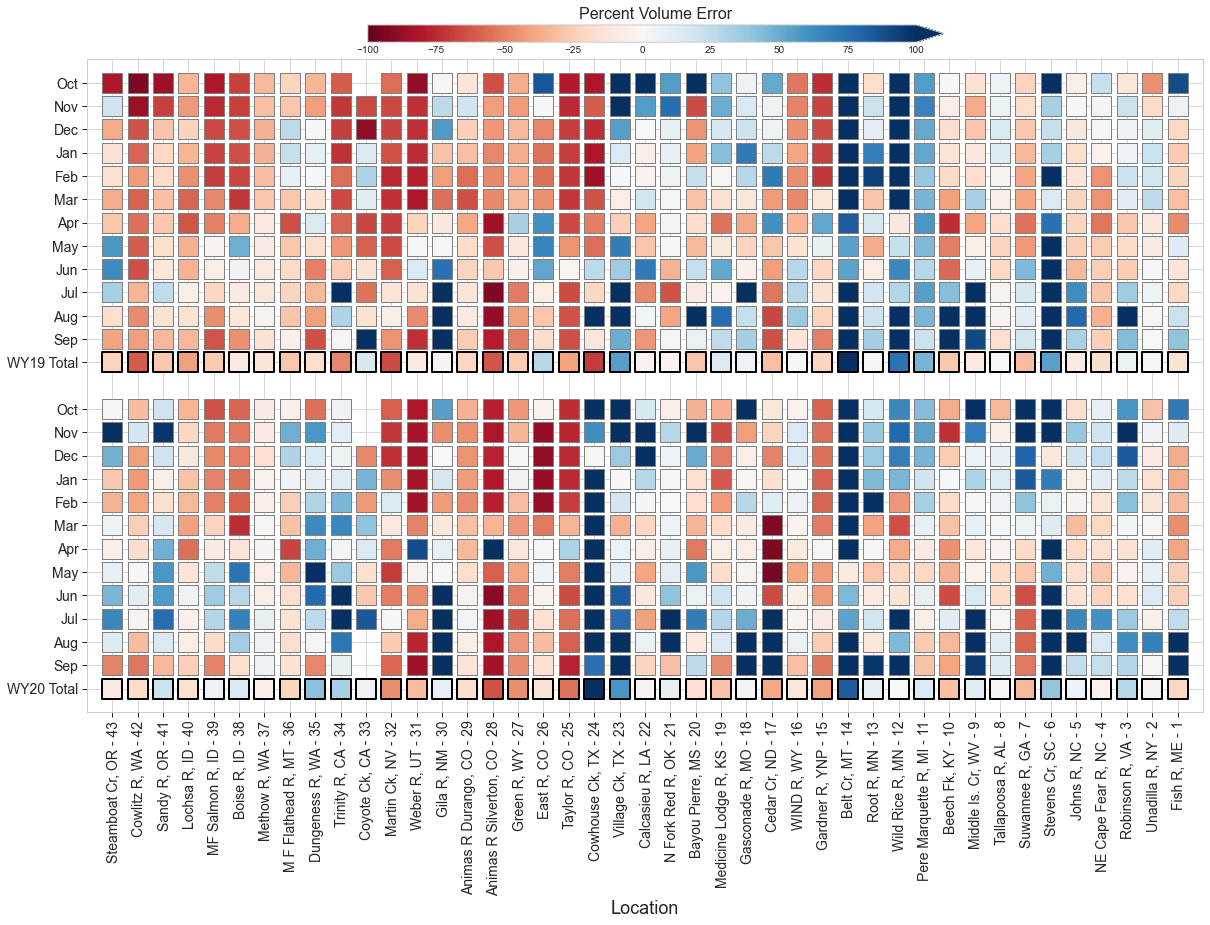

In [8]:
# Figure style 2 - percent error heatmap - seasonal or monthly
# top - WY 19
# bottom - WY 20

#set up variables
timescale = 'M'  # 'M' for monthly, 'S' for seasonal

if timescale == 'M':
    fig_filename = "PercError_Heatmap_Monthly.png"
    fig_title = "Percent Error by Month and Water Year"
    ytlabels = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May",
                "Jun", "Jul", "Aug", "Sep", "WY19 Total", 
                "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", 
                "Jun", "Jul", "Aug", "Sep", "WY20 Total"]
    ytlabels = ytlabels[::-1]
    ytickvals = np.concatenate((np.arange(13)+1, np.arange(13)+15), axis=0)
    ymax = 28
    nrows_per_wy = 13
    ax_height = 12
    colorbar_specs = [0.32, 0.9, 0.4, 0.02]
else:
    fig_filename = "PercError_Heatmap_Seasonal.png"
    fig_title = "Percent Error by Season and Water Year"
    ytlabels = ["WY20 Total","WY20 Jul-Sep","WY20 Apr-Jun","WY20 Jan-Mar","WY20 Oct-Dec",
                "WY19 Total","WY19 Jul-Sep","WY19 Apr-Jun","WY19 Jan-Mar","WY19 Oct-Dec"]
    ytickvals = [1,2,3,4,5,7,8,9,10,11] # leave 6 position blank
    ymax = 12
    nrows_per_wy = 5
    ax_height = 5
    colorbar_specs = [0.32, 0.95, 0.4, 0.05]
    
# set up axes
fig, ax1 = plt.subplots(1,1,figsize = (20, ax_height))

# x-axis num ticks = # of sites for all axes, all time scales
site_labels = site_labels_numlast # labels with right justified site num for bottom x axes
xlen = len(site_labels)

# set up ticks and labels
ax1.set_xticks(np.arange(xlen))
ax1.set_xlim(-1,len(site_labels))
ax1.set_xticklabels(site_labels, rotation=90, ha="right", va="center_baseline",
         rotation_mode="anchor", fontsize = 14)
ax1.set_xlabel("Location", fontsize = 18)
ax1.tick_params(direction='out', length=5, width=1)
ax1.set_ylim(0,ymax)
ax1.set_yticks(ytickvals)
ax1.set_yticklabels(ytlabels, fontsize = 14)

for wy in range(19,21): 
    for i in range(1, nrows_per_wy + 1):
        if i == nrows_per_wy:
            vals = annual_err_perc.loc[wy,:]
            ecol = 'black'
            lw = 2
        else:
            if timescale == 'M':
                vals = mon_err_perc[mon_err_perc['WY'].eq(wy)].iloc[i-1,2:]
            else:
                vals = seas_err_perc[seas_err_perc['WY'].eq(wy)].loc[i,site_ids]
            ecol = 'gray'
            lw = 1
        plotpos = (21-wy)*(nrows_per_wy + 1) - i
        squares = ax1.scatter(np.arange(xlen), np.full((1,xlen),plotpos), 
            c=vals, cmap = 'RdBu', vmin=-100, vmax=100, 
            marker='s', s=np.full((1,xlen),400), edgecolor=ecol, linewidth = lw)

#add colorbar
cax = fig.add_axes(colorbar_specs)
cax.set_title('Percent Volume Error', fontsize=16)
cb = fig.colorbar(squares, cax=cax, orientation='horizontal', fraction=0.1, extend="max")
plt.savefig(fig_filename, dpi=150, bbox_inches = "tight")

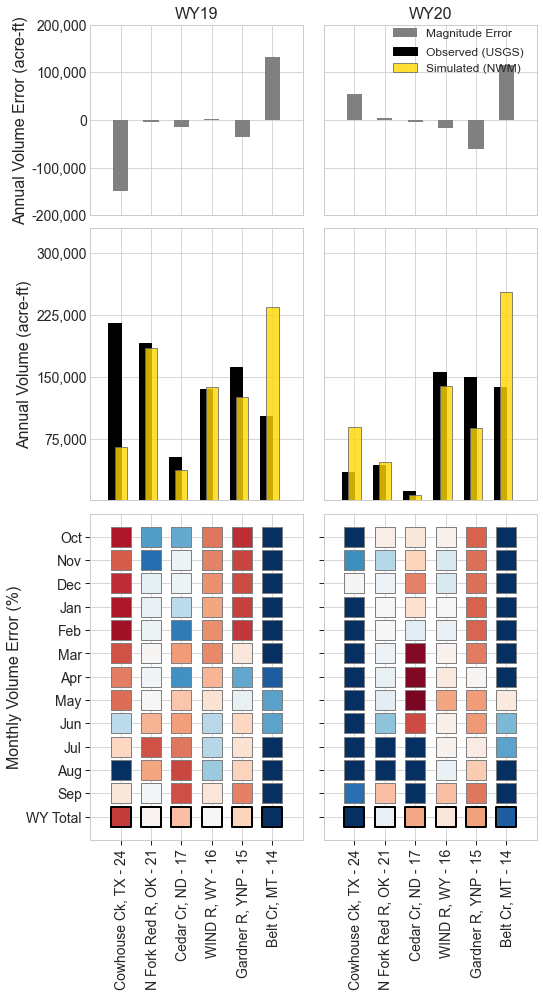

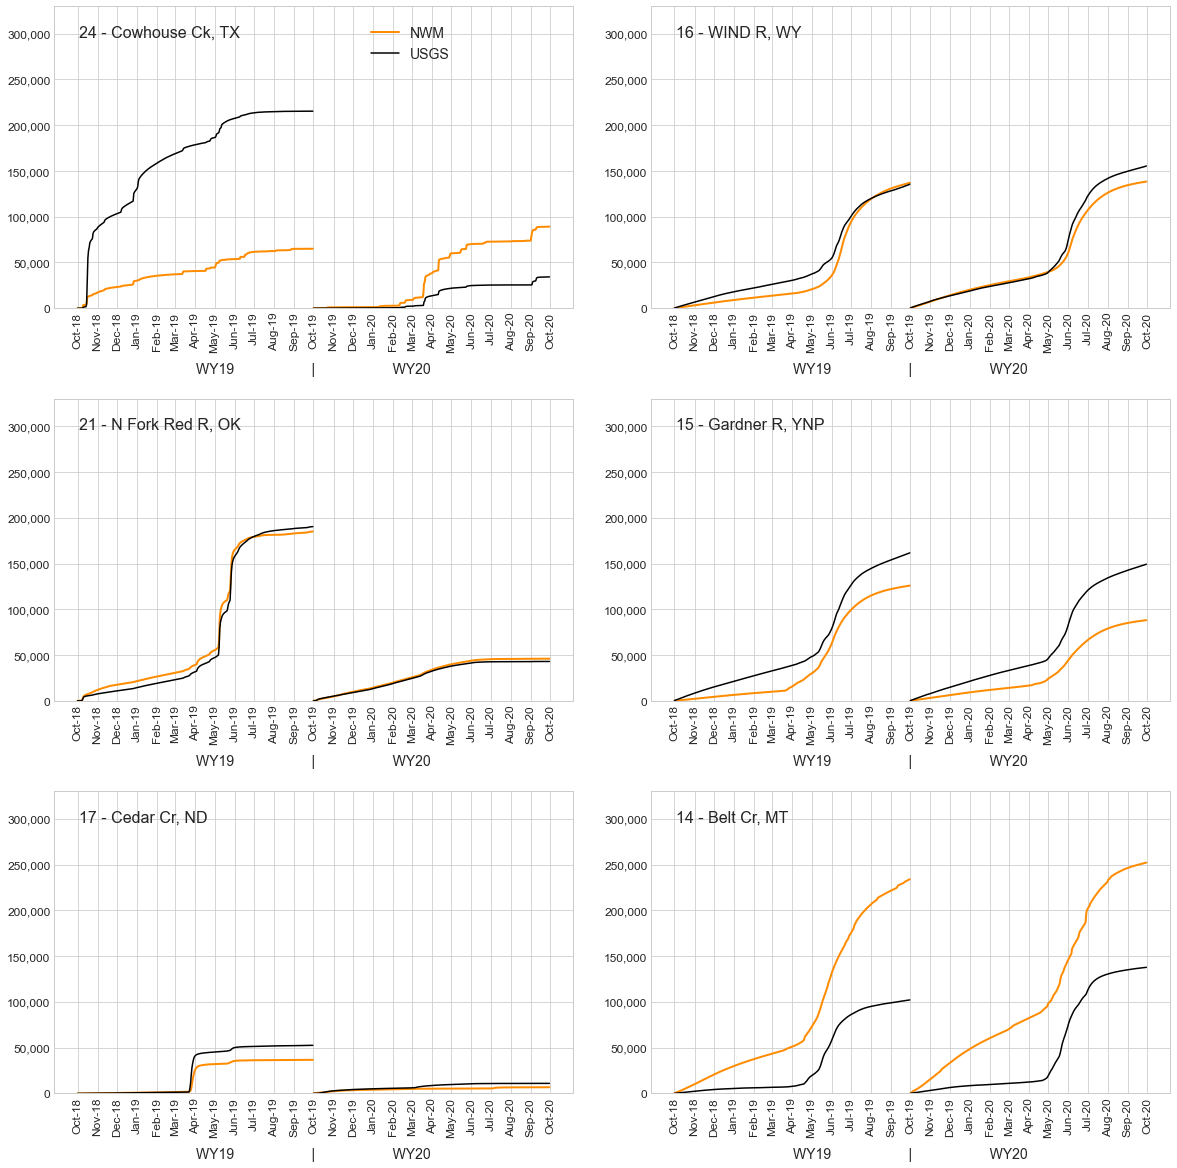

In [9]:
# Figure style 3 - combo annual barcharts and monthly heatmap for 6 locations at a time

curr_group = 8  # currently manually selecting group rather than looping

ylim1 = [1e6, 1e6, 5e5, 1e6, 1e6, 1e6, 1e5, 2e5]
ylim2 = [2e6, 2e6, 1e6, 2e6, 2e6, 2e6, 2e5, 3e5]

ylim_top = ylim1[curr_group-1]
ylim_mid = ylim2[curr_group-1]

yticks_top = [-ylim_top, -ylim_top/2, 0, ylim_top/2, ylim_top]
yticks_mid = [ylim_mid*.25, ylim_mid*.5, ylim_mid*.75, ylim_mid]

# setup groups of sites
site_groups = [[43, 42, 41, 37, 35, 34], [40, 39, 38, 36, 27], [31, 29, 28, 27, 26, 25], 
               [18, 19, 20, 22, 23, 10], [13, 12, 11, 9, 2, 1], [8, 7, 6, 5, 4, 3], 
               [33, 32, 31, 30, 28, 25], [24, 21, 17, 16, 15, 14]]

# setup groups of sites
groupnames = ['PNW1', 'NRockies', 'SRockies', 'South', 'NEast-Cen', 'SEast', 
               'lowgroup1', 'lowgroup2']

# site_nums of 6 sites to include, any order 
site_subset = site_groups[curr_group-1]
combo_fname = 'ComboPlot_Sites_' + groupnames[curr_group-1] +'.png'
dailyacc_fname = 'DailyAccum_Sites_' + groupnames[curr_group-1] +'.png'

site_ids_subset = sites_df.loc[site_subset, :].loc[:,'USGS_ID']
site_labels_subset = site_labels_numlast.loc[site_subset]
xlen = len(site_subset)

# set up and size 6 axes
fig = plt.figure(figsize=(8,15))
gs  = gridspec.GridSpec(3, 2, height_ratios=[0.7, 1 ,1.2])
axtop = [plt.subplot(gs[0]), plt.subplot(gs[1])]
axmid = [plt.subplot(gs[2]), plt.subplot(gs[3])]
axbot = [plt.subplot(gs[4]), plt.subplot(gs[5])]
plt.subplots_adjust(hspace=0.05, wspace = 0.1)

# all axes left = WY19, right = WY20

# top axes - bar charts of annual error magnitude
for wy in range(19,21):
    ax = axtop[wy-19]
    err_mag = annual_err_mag.loc[wy,site_ids_subset]
    ax.bar(np.arange(xlen), err_mag, width=0.5, color='gray', label="Magnitude Error")
    ax.set_xticks(np.arange(xlen))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlim(-1,xlen)
    ax.set(xticks = np.arange(xlen), ylim=(-ylim_top, ylim_top));
    ax.set_yticks(yticks_top)
    ax.set_ylim(-ylim_top, ylim_top)
    if wy == 19:
        ax.set_ylabel("Annual Volume Error (acre-ft)", fontsize = 16)
        ax.tick_params(axis='y', labelsize=14)
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_title("WY19", fontsize = 16)
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.set_title("WY20", fontsize = 16)
        ax.legend(loc=(.3,.9), fontsize = 12)
        
# middle axes - bar charts of observed vs simulated annual volume
for wy in range(19,21):
    ax = axmid[wy-19]
    usgs_vals = usgs_annual.loc[wy,site_ids_subset]
    nwm_vals = nwm_annual.loc[wy,site_ids_subset]
    width = 0.4  # bar width, set by trial and error
    ax.bar(np.arange(xlen)-width/2, usgs_vals, width=width, label="Observed (USGS)", color="black", edgecolor='black')
    ax.bar(np.arange(xlen), nwm_vals, width=width, label="Simulated (NWM)", alpha = 0.8, color="gold", edgecolor='dimgray')
    ax.set_xticks(np.arange(xlen))
    ax.set_xlim(-1,xlen)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
 #   ax.tick_params(direction='out', length=5, width=1)
    ax.set_ylim(0, ylim_mid*1.1)
    ax.set_yticks(yticks_mid)
    if wy == 19:
        ax.set_ylabel("Annual Volume (acre-ft)", fontsize = 16)
        ax.tick_params(axis='y', labelsize=14)
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.legend(loc=(.3,1.55), fontsize = 12)
    
# bottom axes - monthly heatmap
for wy in range(19,21):
    ax = axbot[wy-19]

    # set up ticks and labels
    ax.set_xticks(np.arange(xlen))
    ax.set_xlim(-1,xlen)
    ax.set_xticklabels(site_labels_subset, rotation=90, ha="right", va="center_baseline",
             rotation_mode="anchor", fontsize = 14)
    ax.tick_params(direction='out', length=5, width=1)
    ax.set_yticks(np.arange(13)+1)
    ax.set_ylim(0,14)
    
    months = pd.date_range("2020-10-01", periods=12, freq="M")
    monthnums = months.month
    monthstr = months.strftime("%b")
    nrows_per_wy = 13
    for i in range(1, nrows_per_wy + 1):
        if i == nrows_per_wy:
            vals = annual_err_perc.loc[wy,site_ids_subset]
            ecol = 'black'
            lw = 2
        else:
            vals = mon_err_perc[mon_err_perc['WY'].eq(wy)].loc[monthnums[i-1],site_ids_subset]
            ecol = 'gray'
            lw = 1
        plotpos = 14 - i
        squares = ax.scatter(np.arange(xlen), np.full((1,xlen),plotpos),c=vals, 
                             cmap = 'RdBu', vmin=-100, vmax=100, marker='s', 
                             s=np.full((1,xlen),400), edgecolor=ecol, linewidth = lw)
    if wy == 19:
        ytlabels = np.append(monthstr, ['WY Total'])
        ytlabels = ytlabels[::-1]
        ax.set_yticklabels(ytlabels, fontsize = 14)
        ax.set_ylabel("Monthly Volume Error (%)", fontsize = 16)
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        
plt.savefig(combo_fname, dpi=150, bbox_inches = "tight")

# Figure style 4 - cumulative daily volume, sim vs obs
# set up axes
fig, axs = plt.subplots(nrows = 3, ncols = 2,figsize = (20,20))
plt.subplots_adjust(hspace=0.3, wspace = 0.15)

site_labels_subset = site_labels_numfirst.loc[site_subset]
s = 0
for j in np.arange(2): #subplot rows
    for i in np.arange(3):  #subplot cols
        if s == xlen:
            break
        nsite = site_subset[s]
        location_id = site_ids_subset[nsite]
        location_name = site_labels_subset[nsite]

        axs[i,j].plot(nwm_dailyaccum19.loc[:,location_id], 'darkorange', label="NWM", linewidth = 2)
        axs[i,j].plot(usgs_dailyaccum19.loc[:,location_id], 'black', label="USGS" )
        
        axs[i,j].plot(nwm_dailyaccum20.loc[:,location_id], 'darkorange', linewidth = 2)
        axs[i,j].plot(usgs_dailyaccum20.loc[:,location_id], 'black')
        
        axs[i,j].set_xticks(pd.date_range(start='10/1/2018', end='11/1/2020', freq='M') - pd.offsets.MonthBegin(1))
        spaces = ' ' * 20
        axs[i,j].set_xlabel('WY19' + spaces + '|' + spaces + 'WY20', fontsize = 14, labelpad = 10)
        axs[i,j].tick_params(axis='x', labelsize = 12, rotation = 90)
        axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        axs[i,j].tick_params(axis='y', labelsize = 12)
        axs[i,j].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axs[i,j].set_ylim(0,ylim_mid*1.1)
        axs[i,j].text(mdates.datestr2num('10/3/2018'),ylim_mid*1.1*0.9, location_name, fontsize = 16)
        if s == 0:
            axs[i,j].legend(loc=(.6,.8), fontsize = 14)
        s += 1
            
plt.savefig(dailyacc_fname, dpi=150, bbox_inches = "tight")